In [1]:
pip install "u8darts[all]"

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install "u8darts[notorch]"

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import required libraries

import logging

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL

from darts import concatenate
from darts import TimeSeries

from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import (
    Diff,
    InvertibleMapper,
    Mapper,
    MissingValuesFiller,
    Scaler,
)

from darts.ad import (
    ForecastingAnomalyModel,
    KMeansScorer,
    NormScorer,
    WassersteinScorer,
)

from darts.ad.utils import (
    eval_metric_from_scores,
    show_anomalies_from_scores,
)

from darts.utils.missing_values import fill_missing_values
from darts.utils.statistics import check_seasonality
from darts.metrics import mae, mape, rmse, sape, smape 
from darts.models.filtering.moving_average_filter import MovingAverageFilter

from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    ExponentialSmoothing,
    VARIMA,
    AutoARIMA,
    RegressionModel,
    LinearRegressionModel,
    LightGBMModel,
    XGBModel,
    CatBoostModel,
    NHiTSModel,
    Prophet,
    BlockRNNModel,
    TCNModel,
    DLinearModel,
    NLinearModel,
    TFTModel,
    TSMixerModel,
)

from sklearn.linear_model import Ridge

In [4]:
from darts.utils.callbacks import TFMProgressBar
from darts.utils.timeseries_generation import (
    datetime_attribute_timeseries,
    sine_timeseries,
)

logging.disable(logging.CRITICAL)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [5]:
# Load datasets

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("train.csv")
df_transactions = pd.read_csv("transactions.csv")
df_stores = pd.read_csv("stores.csv")
df_holidays = pd.read_csv("holidays_events.csv")

df_oil_full = pd.read_csv("oil.csv")
df_oil = df_oil_full[(df_oil_full['date'] >= '2013-01-01') & (df_oil_full['date'] <= '2017-08-15')]
df_gold_full = pd.read_csv("gold.csv")
df_gold = df_gold_full[(df_gold_full['date'] >= '2013-01-01') & (df_gold_full['date'] <= '2017-08-15')]
df_fx_full = pd.read_csv("fx.csv")
df_fx = df_fx_full[(df_fx_full['date'] >= '2013-01-01') & (df_fx_full['date'] <= '2017-08-15')]

# 1. EDA

In [6]:
# Display some dataset info

for df in (df_train, df_transactions, df_stores, df_holidays, df_oil, df_gold, df_fx):
    print("\nDataFrame Info:")
    df.info()
    print("\nFirst 5 rows:\n",df.head())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB

First 5 rows:
    id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dat

In [7]:
# Convert True/False to 1/0
df_holidays['transferred'] = df_holidays['transferred'].astype(float) 

In [8]:
# Convert 'date' columns to datetime objects
df_train['date'] = pd.to_datetime(df_train['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_gold['date'] = pd.to_datetime(df_gold['date'])
df_fx['date'] = pd.to_datetime(df_fx['date'])

# Univariate Analysis

In [9]:
# Create seasonal_decomposition function
def seasonal_decomposition(df, col, period):
    stl = STL(df[col], period=period) 
    result = stl.fit()

    seasonal = result.seasonal
    trend = result.trend
    resid = result.resid

    result.plot()
    plt.show()

In [10]:
# Sales Summary Statistics
df_train.describe()

,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


In [11]:
# Calculate total daily sales from df_train by date and convert into Time Series objects
df_total_sales = df_train.groupby(['date'])['sales'].sum().reset_index()
df_daily_sales = df_total_sales.sort_values(by='date')

In [12]:
# Daily Sales Summary Statistics
df_daily_sales.describe()

,date,sales
count,1684,1.684000e+03
mean,2015-04-24 08:27:04.703088128,6.375564e+05
min,2013-01-01 00:00:00,2.511619e+03
25%,2014-02-26 18:00:00,4.427115e+05
50%,2015-04-24 12:00:00,6.321889e+05
75%,2016-06-19 06:00:00,7.859455e+05
max,2017-08-15 00:00:00,1.463084e+06
std,NaN,2.344102e+05


In [13]:
daily_sales = TimeSeries.from_dataframe(df_daily_sales, time_col='date', value_cols='sales', fill_missing_dates=True, freq='D', fillna_value=0, static_covariates=None, hierarchy=None)
scaler_daily = Scaler()
daily_scaled = scaler_daily.fit_transform(daily_sales)  # Fit and transform the TimeSeries

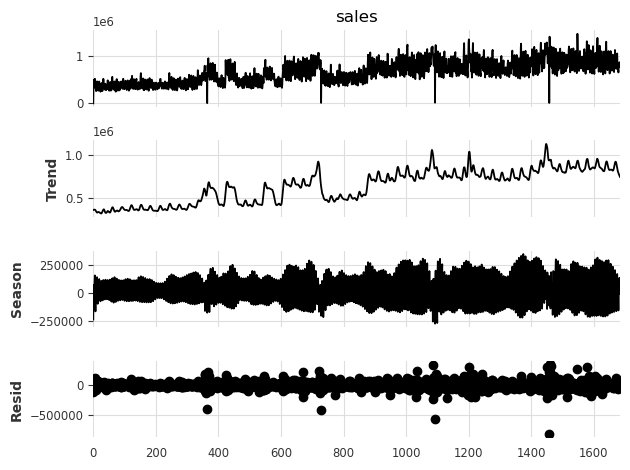

In [14]:
# Seasonal Decomposition of Sales
# Weekly seasonality
seasonal_decomposition(df_daily_sales, 'sales', 7)

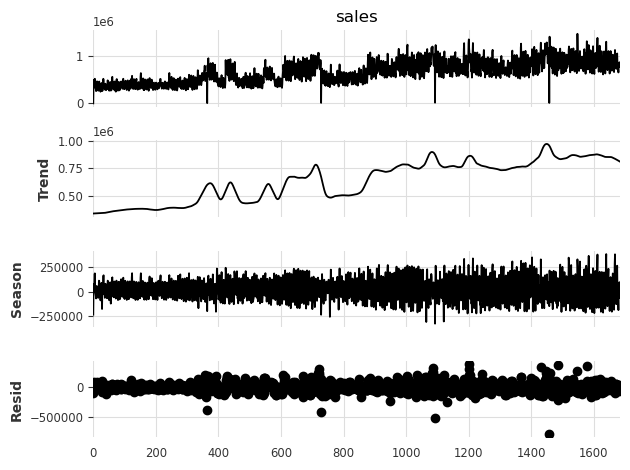

In [15]:
# Monthly seasonality
seasonal_decomposition(df_daily_sales, 'sales', 28)

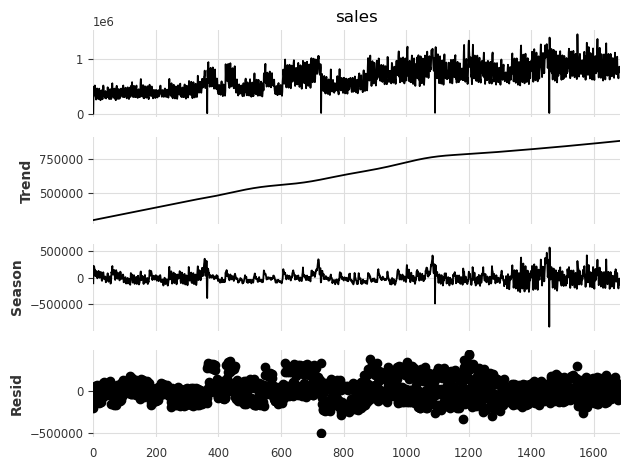

In [16]:
# Yearly seasonality
seasonal_decomposition(df_daily_sales, 'sales', 365)

In [17]:
# Transactions Summary Statistics
df_transactions.describe()

,date,store_nbr,transactions
count,83488,83488.000000,83488.000000
mean,2015-05-20 16:07:40.866232064,26.939237,1694.602158
min,2013-01-01 00:00:00,1.000000,5.000000
25%,2014-03-27 00:00:00,13.000000,1046.000000
50%,2015-06-08 00:00:00,27.000000,1393.000000
75%,2016-07-14 06:00:00,40.000000,2079.000000
max,2017-08-15 00:00:00,54.000000,8359.000000
std,NaN,15.608204,963.286644


In [18]:
# Calculate total daily transactions from df_transactions by date and convert into Time Series objects
df_total_transactions = df_transactions.groupby(['date'])['transactions'].sum().reset_index()
df_daily_transactions = df_total_transactions.sort_values(by='date')

In [19]:
daily_transactions = TimeSeries.from_dataframe(df_daily_transactions, time_col='date', value_cols='transactions', fill_missing_dates=True, freq='D', fillna_value=0, static_covariates=None, hierarchy=None)
scaler_daily_transactions = Scaler()
daily_transactions_scaled = scaler_daily_transactions.fit_transform(daily_transactions)  # Fit and transform the TimeSeries

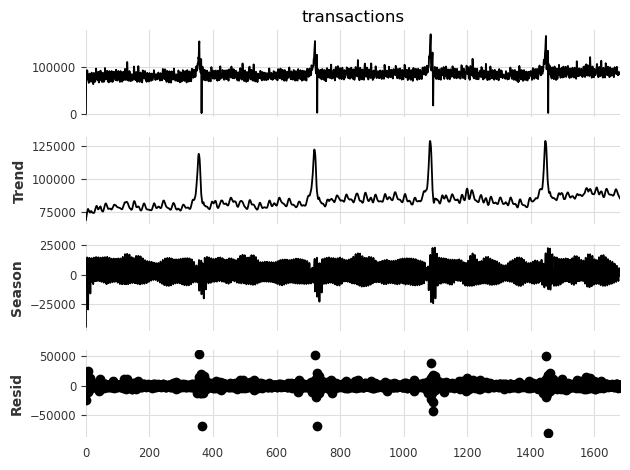

In [20]:
# Seasonal Decomposition of Transactions
# Weekly seasonality
seasonal_decomposition(df_daily_transactions, 'transactions', 7)

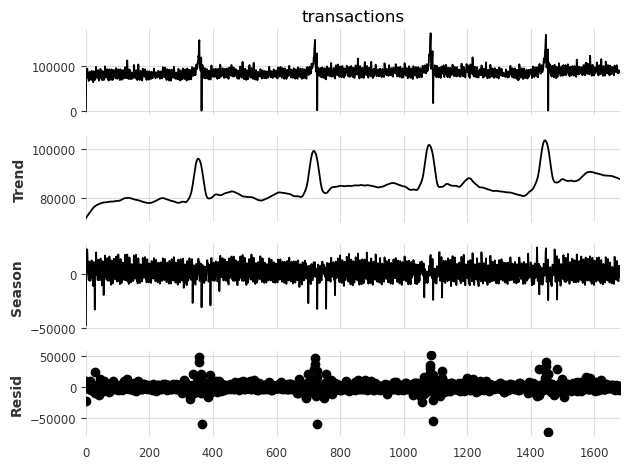

In [21]:
# Monthly seasonality
seasonal_decomposition(df_daily_transactions, 'transactions', 28)

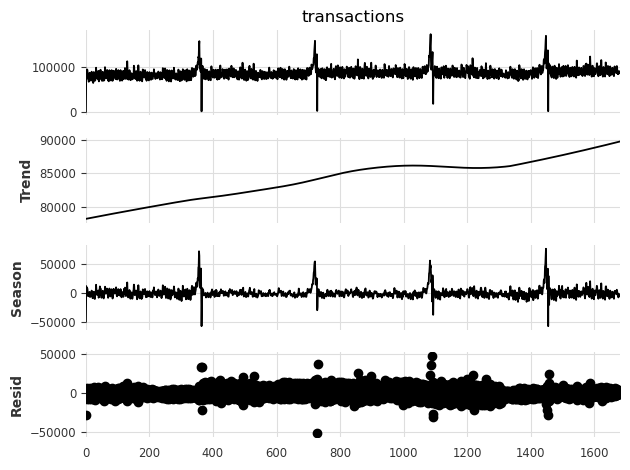

In [22]:
# Yearly seasonality
seasonal_decomposition(df_daily_transactions, 'transactions', 365)

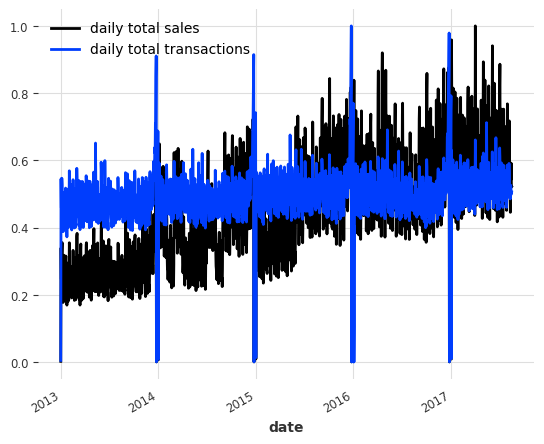

In [23]:
# Plot Sales & Transactions together
daily_scaled.plot(label="daily total sales")
daily_transactions_scaled.plot(label="daily total transactions")
plt.legend()

In [24]:
# Distribution Analysis
# Create hisplot and boxplot function
def histplot(df, feature):

    plt.figure(figsize=(8, 6))
    sns.histplot(np.log(df[feature]), kde=True) #Histogram with KDE
    plt.title(f"Distribution of {feature}")
    plt.show()

def boxplot(df, feature):
    plt.figure(figsize=(8,6))
    sns.boxplot(y=np.log(df[feature])) #Boxplot for Outliers
    plt.title(f"Boxplot of {feature}")
    plt.show()

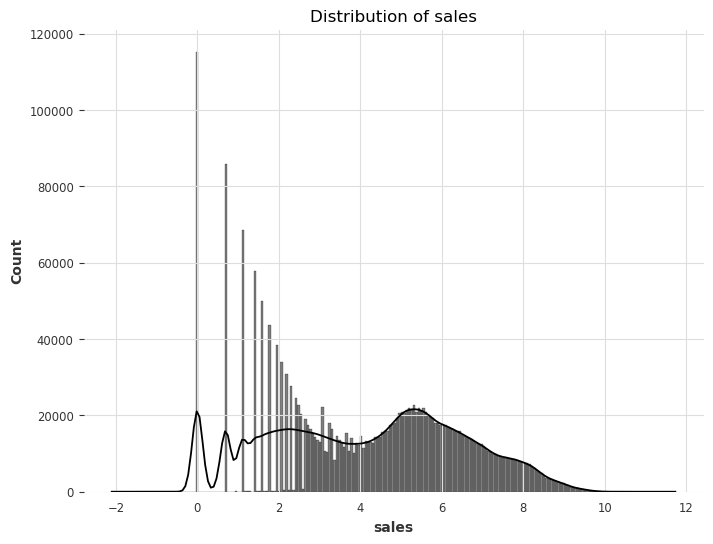

In [25]:
# Distribution plot for sales
histplot(df_train, 'sales')

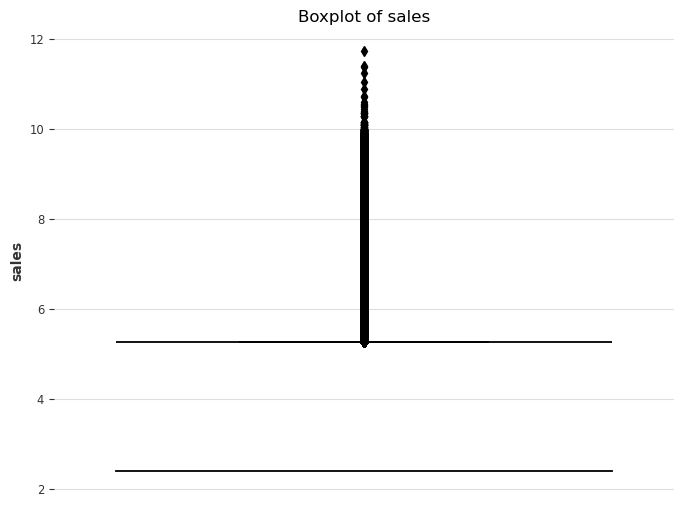

In [26]:
boxplot(df_train, 'sales')

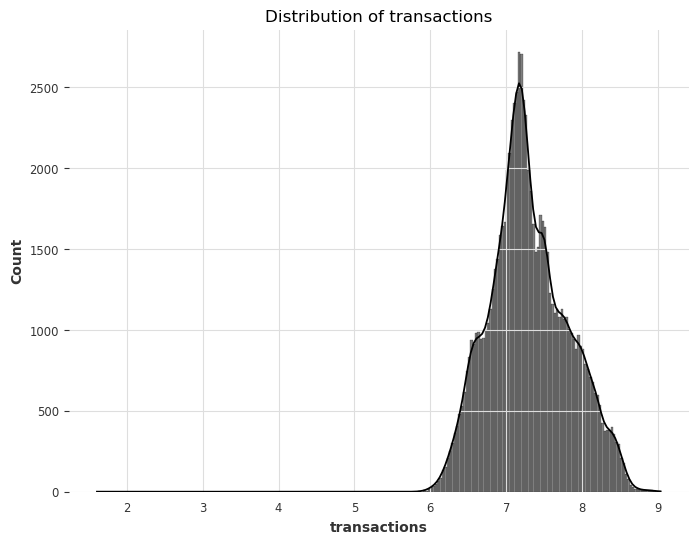

In [27]:
# Distribution plot for transactions
histplot(df_transactions, 'transactions')

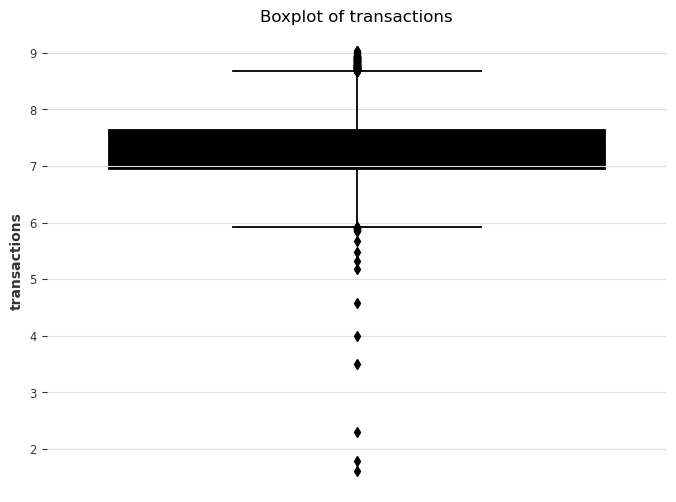

In [28]:
boxplot(df_transactions, 'transactions')

In [29]:
# Create reindex_timeseries function
def reindex_timeseries(ts):
    date = pd.date_range(start='2013-01-01', end='2017-08-15', freq='D')
    new_df = pd.DataFrame(index=date)  # Create empty DataFrame with new index

    # Merge the original TimeSeries into the new DataFrame
    merged_df = new_df.merge(ts.pd_dataframe(), how='left', left_index=True, right_index=True)

    # Convert back to Darts TimeSeries
    ts = TimeSeries.from_dataframe(merged_df, value_cols=ts.columns)  # Specify value columns!

    return ts

In [30]:
# Convert df_transactions into TimeSeries objects
transactions_dict = {}

for store, transactions_grouped in df_transactions.groupby(['store_nbr']):
    # Sort by date (important for TimeSeries)
    transactions_grouped = transactions_grouped.sort_values(by='date')

    # Create the TimeSeries
    try:
        transactions = TimeSeries.from_dataframe(transactions_grouped, time_col='date', value_cols='transactions', fill_missing_dates=True, freq='D', fillna_value=0, static_covariates=None, hierarchy=None)
        scaler_transaction = Scaler()
        transactions_scaled = scaler_transaction.fit_transform(transactions)  # Fit and transform the TimeSeries
        transactions_dict[store] = transactions_scaled  # Store the scaled TimeSeries

    except ValueError as e:
        print(f"Error creating TimeSeries for store {store} : {e}")
        continue # Skips to next group if there is a problem
        
print(transactions_dict)

{(1,): <TimeSeries (DataArray) (date: 1687, component: 1, sample: 1)>
array([[[0.69831293]],

       [[0.60635131]],

       [[0.61627522]],

       ...,

       [[0.13761164]],

       [[0.57327158]],

       [[0.5600397 ]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-02 2013-01-03 ... 2017-08-15
  * component  (component) object 'transactions'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None, (2,): <TimeSeries (DataArray) (date: 1687, component: 1, sample: 1)>
array([[[0.58078818]],

       [[0.50073892]],

       [[0.508867  ]],

       ...,

       [[0.40837438]],

       [[0.44039409]],

       [[0.42783251]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-02 2013-01-03 ... 2017-08-15
  * component  (component) object 'transactions'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None, (3,): <TimeSeries (DataArray) (date: 1687, component: 1

In [31]:
# Oil price Summary Statistics
df_oil.describe()

,date,dcoilwtico
count,1206,1163.000000
mean,2015-04-24 02:24:28.656716288,67.925589
min,2013-01-01 00:00:00,26.190000
25%,2014-02-26 06:00:00,46.390000
50%,2015-04-23 12:00:00,53.330000
75%,2016-06-19 06:00:00,95.790000
max,2017-08-15 00:00:00,110.620000
std,NaN,25.677366


In [32]:
# Convert df_oil into TimeSeries objects
oil = TimeSeries.from_dataframe(df_oil, time_col='date', value_cols='dcoilwtico', fill_missing_dates=True, freq='D', fillna_value=None, static_covariates=None, hierarchy=None)
oil_transformer = MissingValuesFiller()
oil_filled = oil_transformer.transform(oil)
scaler_oil = Scaler()
oil_scaled = scaler_oil.fit_transform(oil_filled)  # Fit and transform the TimeSeries
reindex_timeseries(oil_scaled)

<TimeSeries (DataArray) (time: 1688, component: 1, sample: 1)>
array([[[0.79296459]],

       [[0.79296459]],

       [[0.79095108]],

       ...,

       [[0.25828102]],

       [[0.25346441]],

       [[0.25322753]]])
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-15
  * component  (component) object 'dcoilwtico'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [33]:
# Gold price Summary Statistics
df_gold.describe()

,date,gold
count,1206,1206.000000
mean,2015-04-24 02:24:28.656716288,1266.702736
min,2013-01-01 00:00:00,1049.400000
25%,2014-02-26 06:00:00,1198.575000
50%,2015-04-23 12:00:00,1251.800000
75%,2016-06-19 06:00:00,1310.675000
max,2017-08-15 00:00:00,1693.800000
std,NaN,120.261255


In [34]:
# Convert df_gold into TimeSeries objects
gold = TimeSeries.from_dataframe(df_gold, time_col='date', value_cols='gold', fill_missing_dates=True, freq='D', fillna_value=None, static_covariates=None, hierarchy=None)
gold_transformer = MissingValuesFiller()
gold_filled = gold_transformer.transform(gold)
scaler_gold = Scaler()
gold_scaled = scaler_gold.fit_transform(gold_filled)  # Fit and transform the TimeSeries
reindex_timeseries(gold_scaled)

<TimeSeries (DataArray) (time: 1688, component: 1, sample: 1)>
array([[[0.94366853]],

       [[1.        ]],

       [[0.97780881]],

       ...,

       [[0.36338713]],

       [[0.36142148]],

       [[0.3427995 ]]])
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-15
  * component  (component) object 'gold'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [35]:
# FX Summary Statistics
df_fx.describe()

,date,fx
count,1364,1364.000000
mean,2015-03-27 03:54:22.170088192,0.691165
min,2013-01-01 00:00:00,0.642250
25%,2014-01-10 18:00:00,0.655580
50%,2015-03-05 12:00:00,0.706555
75%,2016-06-14 06:00:00,0.719108
max,2017-08-15 00:00:00,0.748770
std,NaN,0.033015


In [36]:
# Convert df_fx into TimeSeries objects
fx = TimeSeries.from_dataframe(df_fx, time_col='date', value_cols='fx', fill_missing_dates=True, freq='D', fillna_value=None, static_covariates=None, hierarchy=None)
fx_transformer = MissingValuesFiller()
fx_filled = oil_transformer.transform(fx)
scaler_fx = Scaler()  
fx_scaled = scaler_fx.fit_transform(fx_filled)  # Fit and transform the TimeSeries
reindex_timeseries(fx_scaled)

<TimeSeries (DataArray) (time: 1688, component: 1, sample: 1)>
array([[[0.06609087]],

       [[0.10805483]],

       [[0.09904243]],

       ...,

       [[0.62708099]],

       [[0.64016147]],

       [[0.63265115]]])
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-15
  * component  (component) object 'fx'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

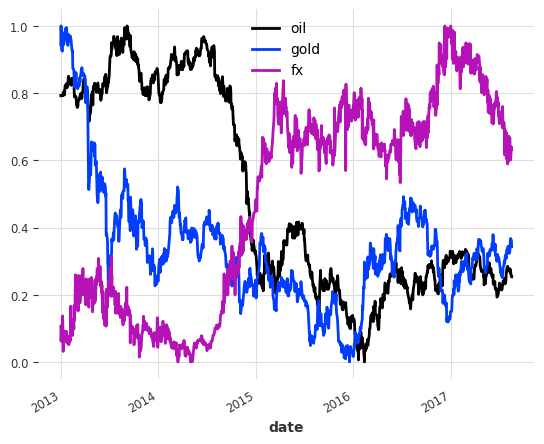

In [37]:
#Plot
oil_scaled.plot(label="oil")
gold_scaled.plot(label="gold")
fx_scaled.plot(label="fx")
plt.legend()

In [38]:
# Checks for stationarity of a Darts TimeSeries using ADFuller and KPSS tests
# Create check_stationarity function 
def check_stationarity(ts, alpha=0.05):
    # Convert Darts TimeSeries to pandas Series (statsmodels works with pandas)
    series = ts.pd_series()

    adf_result = adfuller(series)
    kpss_result = kpss(series, nlags='auto') # Use 'auto' to let KPSS determine lags

    adf_stationary = adf_result[1] > alpha  # p-value > alpha means we fail to reject the null hypothesis (non-stationary)
    kpss_stationary = kpss_result[1] > alpha # p-value > alpha means we fail to reject the null hypothesis (stationary)

    results = {
        'adf_result': {
            'statistic': adf_result[0],
            'pvalue': adf_result[1],
            'stationary': adf_stationary,
        },
        'kpss_result': {
            'statistic': kpss_result[0],
            'pvalue': kpss_result[1],
            'stationary': kpss_stationary,  # Note: Interpretation of KPSS is different!
        },
    }

    return results

In [39]:
# Check for stationarity of daily sales
check_stationarity(daily_scaled, alpha=0.05)

{'adf_result': {'statistic': -2.571413630171664,
  'pvalue': 0.09905058352485002,
  'stationary': True},
 'kpss_result': {'statistic': 5.816378252200235,
  'pvalue': 0.01,
  'stationary': False}}

In [40]:
# Check for stationarity of daily transactions
check_stationarity(daily_transactions_scaled, alpha=0.05)

{'adf_result': {'statistic': -6.295594550295652,
  'pvalue': 3.512357359431535e-08,
  'stationary': False},
 'kpss_result': {'statistic': 3.9307768381914046,
  'pvalue': 0.01,
  'stationary': False}}

In [41]:
# Autocorrelation Analysis
# Create ACF and PACF plot function
def acf_pacf_plot(ts):
    series = ts.pd_series() # Convert to pandas Series
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    plot_acf(series, lags=28, ax=axes[0], title="Autocorrelation Function (ACF)")
    plot_pacf(series,lags=28, ax=axes[1], title="Partial Autocorrelation Function (PACF)", method='ywm')

    plt.tight_layout()
    plt.show()

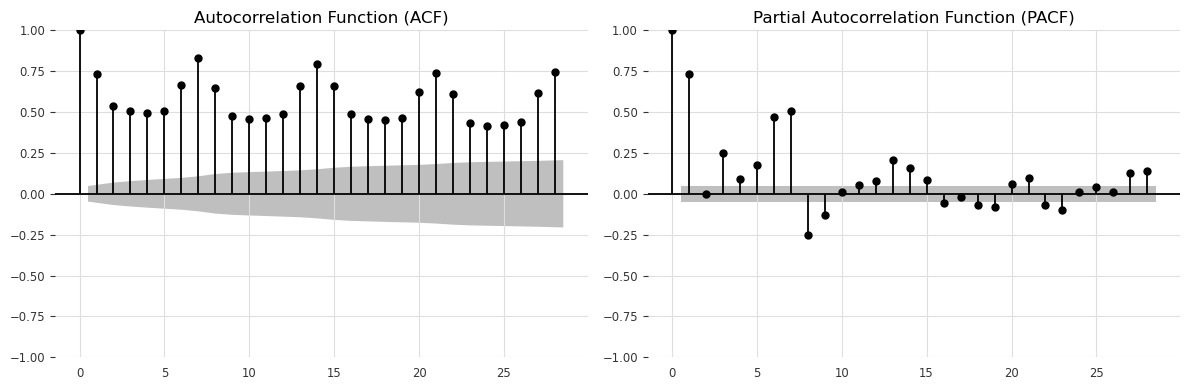

In [42]:
acf_pacf_plot(daily_scaled)

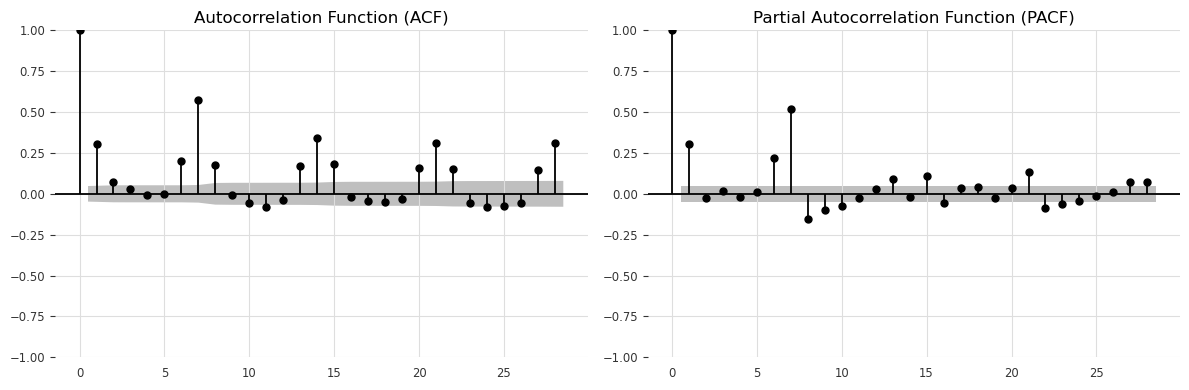

In [43]:
acf_pacf_plot(daily_transactions_scaled)

# Multivariate Analysis

In [44]:
# Correlation Matrix
daily_sales_by_family = df_train.groupby(['family'])
family_list = daily_sales_by_family['family'].unique()

correlation_matrix = pd.DataFrame({
    'Total Sales': daily_scaled.pd_series(),
    'Transactions': daily_transactions_scaled.pd_series(),
    'Oil': oil_scaled.pd_series(),
    'Gold': gold_scaled.pd_series(),
    'FX': fx_scaled.pd_series()
}).corr()

print("Correlation Matrix:\n", correlation_matrix)

Correlation Matrix:
               Total Sales  Transactions       Oil      Gold        FX
Total Sales      1.000000      0.659377 -0.620197 -0.464584  0.623731
Transactions     0.659377      1.000000 -0.213675 -0.218292  0.221193
Oil             -0.620197     -0.213675  1.000000  0.541261 -0.926725
Gold            -0.464584     -0.218292  0.541261  1.000000 -0.531085
FX               0.623731      0.221193 -0.926725 -0.531085  1.000000


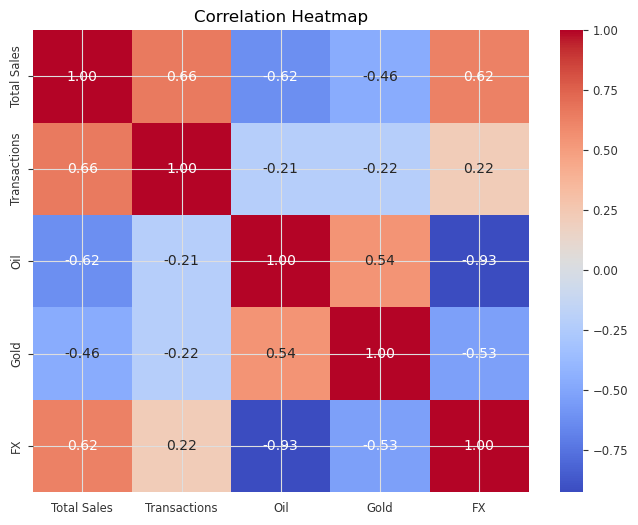

In [45]:
# Heatmap of Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# 2. Preprocessing

In [46]:
# Differencing not needed as sales TimeSeries is already stationary

In [47]:
# Train-Test Split so that the model forecast sales in the next 15 days
train_length = len(daily_scaled) - 15
train = daily_scaled[:train_length]
test = daily_scaled[train_length:]

# 3. Feature Engineering

In [48]:
# Create derive function
def derive(ts):
    
    # Moving Averages
    ma_7 = MovingAverageFilter(window=7)
    ma_28 = MovingAverageFilter(window=28)
    
    moving_average_7 = ma_7.filter(ts)
    moving_average_28 = ma_28.filter(ts)
    
    # Daily Change
    daily_change = ts.diff(n=1, dropna=True)
    weekly_change = ts.diff(n=7, dropna=True)
    monthly_change = ts.diff(n=28, dropna=True)
 
    # Lagged Features (values from previous days)
    lag_1 = ts.shift(1)
    lag_7 = ts.shift(7)  
    lag_28 = ts.shift(28)
    
    derived_features_df = pd.DataFrame({
    'MovingAverage7': moving_average_7.pd_series(),
    'MovingAverage28': moving_average_28.pd_series(),
    'DailyChange': daily_change.pd_series(),
    'WeeklyChange': weekly_change.pd_series(),
    'MonthlyChange': monthly_change.pd_series(),
    'Lag1': lag_1.pd_series(),
    'Lag7': lag_7.pd_series(),
    'Lag28': lag_28.pd_series(),
    })
    
    derived_features = TimeSeries.from_dataframe(derived_features_df, value_cols=['MovingAverage7',
                                                                                  'MovingAverage28',
                                                                                  'DailyChange',
                                                                                  'WeeklyChange',
                                                                                  'MonthlyChange',
                                                                                  'Lag1',
                                                                                  'Lag7',
                                                                                  'Lag28'])
                                                                              
    derived_transformer = MissingValuesFiller()
    derived_features = derived_transformer.transform(derived_features)
    reindex_timeseries(derived_features)
    
    return derived_features

In [49]:
# Derived Features from Sales
daily_sales_scaled_derived = derive(daily_scaled)

In [50]:
# Derived Features from Transactions
daily_transactions_scaled_derived = derive(daily_transactions_scaled)

In [51]:
# Merge into multivariate TimeSeries
sales_transactions_merged = daily_sales_scaled_derived.concatenate(daily_transactions_scaled_derived,axis=1)

In [52]:
# Daily oil price
oil_scaled_derived = derive(oil_scaled)
oil_scaled.head()

<TimeSeries (DataArray) (date: 5, component: 1, sample: 1)>
array([[[0.79296459]],

       [[0.79296459]],

       [[0.79095108]],

       [[0.7927277 ]],

       [[0.79304355]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-01-05
  * component  (component) object 'dcoilwtico'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [53]:
# Daily gold price
gold_scaled_derived = derive(gold_scaled)
gold_scaled.head()

<TimeSeries (DataArray) (date: 5, component: 1, sample: 1)>
array([[[0.94366853]],

       [[1.        ]],

       [[0.97780881]],

       [[0.92892613]],

       [[0.92752948]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-01-05
  * component  (component) object 'gold'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [54]:
# Daily fx
fx_scaled_derived = derive(fx_scaled)
fx_scaled.head()

<TimeSeries (DataArray) (date: 5, component: 1, sample: 1)>
array([[[0.06609087]],

       [[0.10805483]],

       [[0.09904243]],

       [[0.06064589]],

       [[0.06092753]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-01-05
  * component  (component) object 'fx'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [55]:
# Merge into multivariate TimeSeries
macro_merged = oil_scaled_derived.concatenate(gold_scaled_derived,axis=1).concatenate(fx_scaled_derived,axis=1)

In [56]:
# Weekend
dates = pd.date_range(start='2013-01-01', end='2017-08-15', freq='D')
weekend_df = pd.DataFrame({'weekend': 0}, index=dates)  # Initialize all to 0 (weekday)

weekend_df.loc[weekend_df.index.dayofweek >= 5, 'weekend'] = 1  # 5 and 6 represent Saturday and Sunday

In [57]:
# Payday: Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month
payday_df = pd.DataFrame({'payday': 0}, index=dates)  # Initialize all to 0
last_days = dates[dates.to_series().dt.is_month_end]

payday_df.loc[payday_df.index.day == 15, 'payday'] = 1  
payday_df.loc[last_days, 'payday'] = 1

In [58]:
#Earthquake relief period
earthquake_date = pd.to_datetime('2016-04-16')
relief_period_end = earthquake_date + pd.Timedelta(weeks=4) # Adjustable
earthquake_relief_df = pd.DataFrame({'earthquake': 0}, index=dates)  # Initialize all values to 0
earthquake_relief_df.loc[(earthquake_relief_df.index >= earthquake_date) & (earthquake_relief_df.index <= relief_period_end)] = 1

In [59]:
# Holidays
holiday_df = pd.DataFrame({'holiday': 0, 'transferred':0}, index=dates)   # Initialize all to 0

for holiday_date in df_holidays['date']:
        if holiday_date in df.index:
            holiday_df.loc[holiday_date, 'holiday'] = 1
            if holiday_date in df_holidays.index and 'transferred' in df_holidays.columns: # check if date exists in df_holidays and if transferred is a column
                transferred_value = df_holidays.loc[holiday_date, 'transferred']
                if transferred_value > 0:
                    holiday_df.loc[holiday_date, 'transferred'] = 1

In [60]:
# Merge into multivariate TimeSeries
calendar_merged_df = weekend_df.join(payday_df, how='outer').join(holiday_df, how='outer').join(earthquake_relief_df, how='outer')
calendar_merged = TimeSeries.from_dataframe(calendar_merged_df, value_cols=['weekend', 'payday', 'holiday','earthquake'])

# 4. Develop & Evaluate Forecast Models

In [61]:
# Create compute_error_metrics function to get evaluation metrics
def compute_error_metrics(actual_series, predicted_series):
    
    # Mean Absolute Error (MAE)
    mae_value = mae(actual_series, predicted_series)
    print(f"MAE: {mae_value}")
    
    # Mean Absolute Percentage Error (MAPE)
    mape_value = mape(actual_series, predicted_series)
    print(f"MAPE: {mape_value}")
    
    # Systeminc Mean Absolute Percentage Error (SMAPE)
    smape_value = smape(actual_series, predicted_series)
    print(f"SMAPE: {smape_value}")
    
    # Root Mean Squared Error (RMSE)
    rmse_value = rmse(actual_series, predicted_series)
    print(f"RMSE: {rmse_value}")


# Baseline Models

<Axes: xlabel='date'>

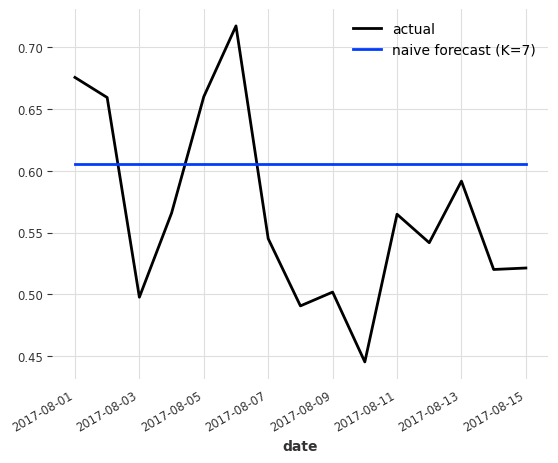

In [62]:
# Naive Forecast

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(15)

daily_scaled[train_length:].plot(label="actual")
naive_forecast.plot(label="naive forecast (K=7)")

In [63]:
# Compute error metrics
compute_error_metrics(test, naive_forecast)

MAE: 0.07767429061277675
MAPE: 14.409662702693582
SMAPE: 13.502384612739064
RMSE: 0.08567493295625678


<Axes: xlabel='date'>

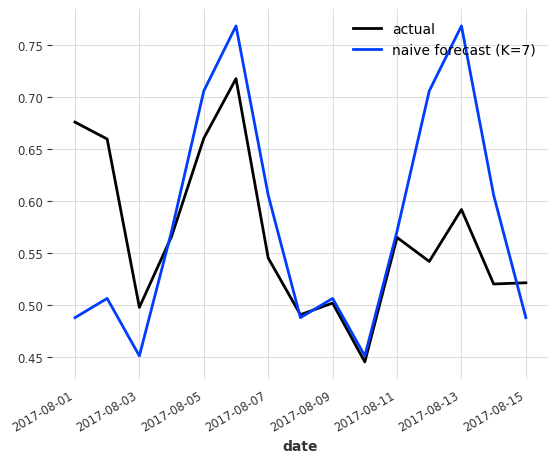

In [64]:
# Naive Seasonal Forecast - Weekly

seasonal_model = NaiveSeasonal(K=7)
seasonal_model.fit(train)
seasonal_forecast_7 = seasonal_model.predict(15)

daily_scaled[train_length:].plot(label="actual")
seasonal_forecast_7.plot(label="naive forecast (K=7)")

In [65]:
# Compute error metrics
compute_error_metrics(test, seasonal_forecast_7)

MAE: 0.06850575142919643
MAPE: 11.538734427950795
SMAPE: 11.409379724261182
RMSE: 0.09512599983078271


<Axes: xlabel='date'>

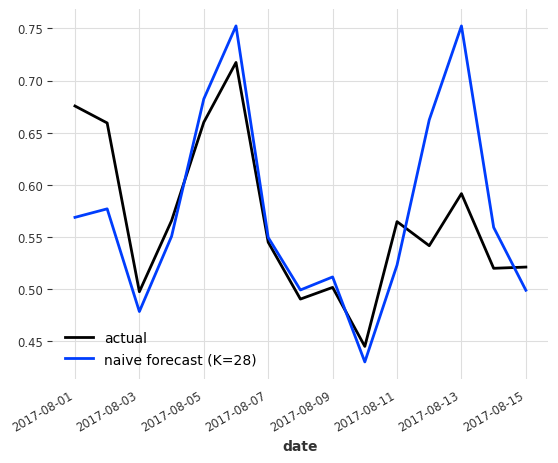

In [66]:
# Naive Seasonal Forecast - Monthly

seasonal_model = NaiveSeasonal(K=28)
seasonal_model.fit(train)
seasonal_forecast_28 = seasonal_model.predict(15)

daily_scaled[train_length:].plot(label="actual")
seasonal_forecast_28.plot(label="naive forecast (K=28)")

In [67]:
# Compute error metrics
compute_error_metrics(test, seasonal_forecast_28)

MAE: 0.04686769919983198
MAPE: 7.971722448525644
SMAPE: 7.75591367990779
RMSE: 0.065849180635292


<Axes: xlabel='date'>

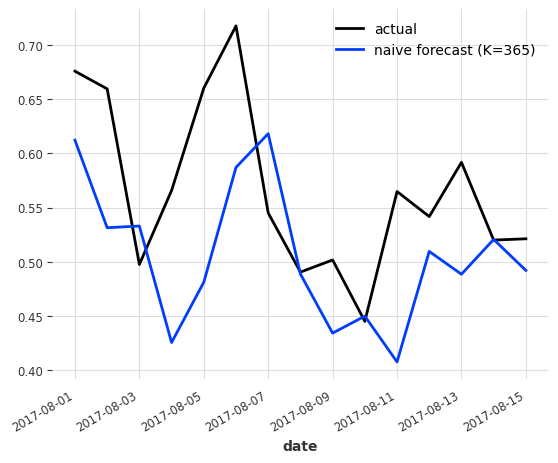

In [68]:
# Naive Seasonal Forecast - Yearly

seasonal_model = NaiveSeasonal(K=365)
seasonal_model.fit(train)
seasonal_forecast_365 = seasonal_model.predict(15)

daily_scaled[train_length:].plot(label="actual")
seasonal_forecast_365.plot(label="naive forecast (K=365)")

In [69]:
# Compute error metrics
compute_error_metrics(test, seasonal_forecast_365)

MAE: 0.07632145270764377
MAPE: 12.735178265216545
SMAPE: 13.966137909225882
RMSE: 0.09565209325464531


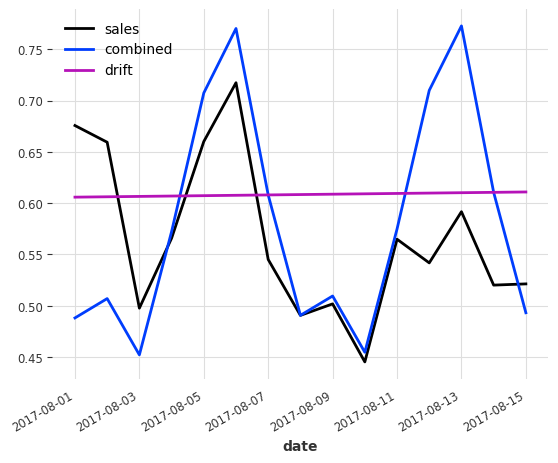

In [70]:
# Naive Dift - Weekly

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast_7 = drift_model.predict(15)

combined_forecast_7 = drift_forecast_7 + seasonal_forecast_7 - train.last_value()

daily_scaled[train_length:].plot()
combined_forecast_7.plot(label="combined")
drift_forecast_7.plot(label="drift");

In [71]:
# Compute error metrics
compute_error_metrics(test, combined_forecast_7)

MAE: 0.07000210007492225
MAPE: 11.80706376162319
SMAPE: 11.624605360447438
RMSE: 0.09654693544006736


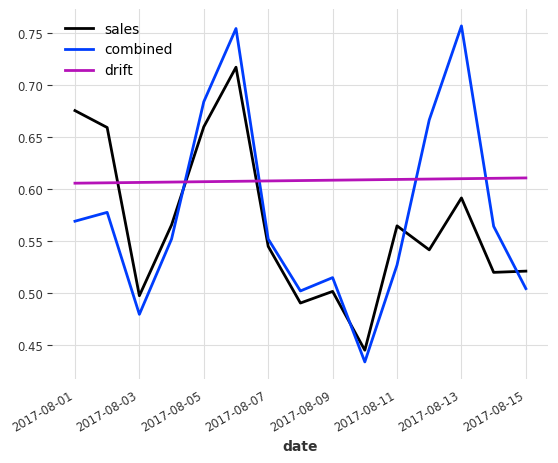

In [72]:
# Naive Dift - Monhtly

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast_28 = drift_model.predict(15)

combined_forecast_28 = drift_forecast_28 + seasonal_forecast_28 - train.last_value()

daily_scaled[train_length:].plot()
combined_forecast_28.plot(label="combined")
drift_forecast_28.plot(label="drift");

In [73]:
# Compute error metrics
compute_error_metrics(test, combined_forecast_28)

MAE: 0.04754174857985365
MAPE: 8.081839740246696
SMAPE: 7.824680339649352
RMSE: 0.06711490969751358


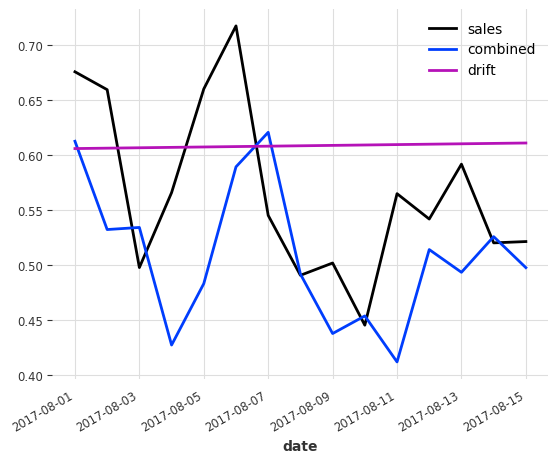

In [74]:
# Naive Dift - Yearly

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast_365 = drift_model.predict(15)

combined_forecast_365 = drift_forecast_365 + seasonal_forecast_365 - train.last_value()

daily_scaled[train_length:].plot()
combined_forecast_365.plot(label="combined")
drift_forecast_365.plot(label="drift");

In [75]:
# Compute error metrics
compute_error_metrics(test, combined_forecast_365)

MAE: 0.07522053547105617
MAPE: 12.55917419571579
SMAPE: 13.727262111697485
RMSE: 0.0940875164959207


# Classic / Statistical Models

<Axes: xlabel='date'>

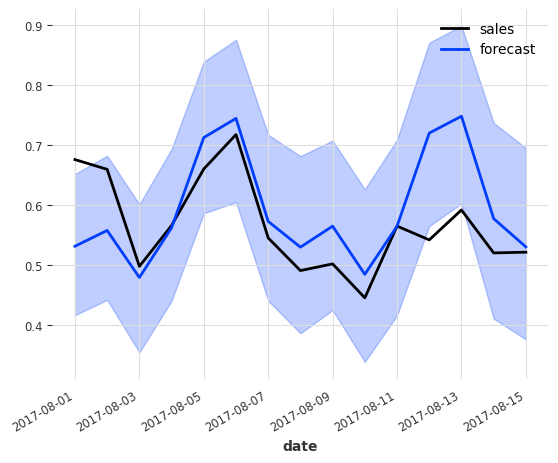

In [76]:
# Exponential Smoothing

exponential_smoothing_model = ExponentialSmoothing()
exponential_smoothing_model.fit(train)
exponential_smoothing_forecast = exponential_smoothing_model.predict(n=15, num_samples=train_length)

daily_scaled[train_length:].plot()
exponential_smoothing_forecast.plot(label='forecast')

In [77]:
# Compute error metrics
compute_error_metrics(test, exponential_smoothing_forecast)

MAE: 0.0611563096933163
MAPE: 10.619881151884652
SMAPE: 10.200302907255292
RMSE: 0.08258970635865504


In [78]:
# Backtest

<Axes: xlabel='date'>

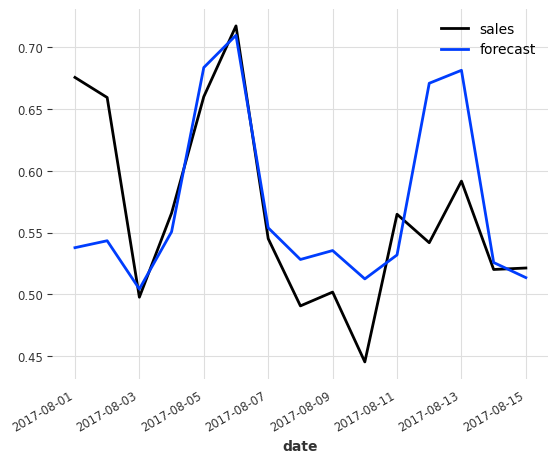

In [79]:
# Auto ARIMA (Automatic Parameter Selection) - with calendar features as future covariates

future_cov = calendar_merged

# Define boundaries for the parameters
arima_model = AutoARIMA(start_p=8, max_p=12, start_q=1)
arima_model.fit(train, future_covariates=future_cov)
arima_forecast = arima_model.predict(15, future_covariates=future_cov)

daily_scaled[train_length:].plot()
arima_forecast.plot(label='forecast')

In [80]:
# Compute error metrics
compute_error_metrics(test, arima_forecast)

MAE: 0.04796454057747147
MAPE: 8.343953565470118
SMAPE: 8.2763218801538
RMSE: 0.06654802671547541


<Axes: xlabel='date'>

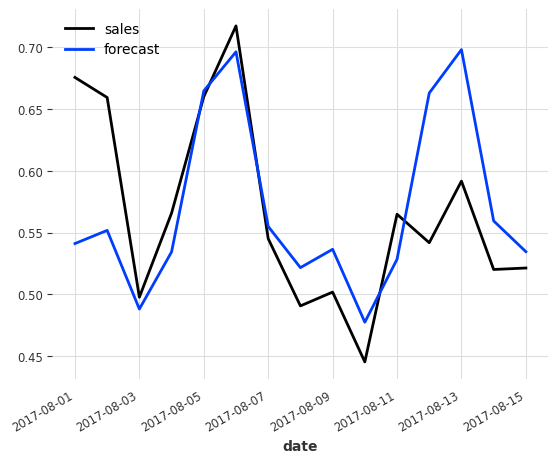

In [81]:
# Facebook Prophet - with standard features

future_cov = calendar_merged
# adding a seasonality
prophet_model = Prophet(
    add_seasonalities={
        'name':"monthly_seasonality",
        'seasonal_periods':28,
        'fourier_order':2
        },
)
prophet_model.fit(train, future_covariates=future_cov)
prophet_forecast = prophet_model.predict(15, future_covariates=future_cov)

daily_scaled[train_length:].plot()
prophet_forecast.plot(label='forecast')

In [82]:
# Compute error metrics
compute_error_metrics(test, prophet_forecast)

MAE: 0.04889002665601889
MAPE: 8.437096850527617
SMAPE: 8.393739980064494
RMSE: 0.06512515319070648


In [83]:
# Backtest

# Regression Models

<Axes: xlabel='date'>

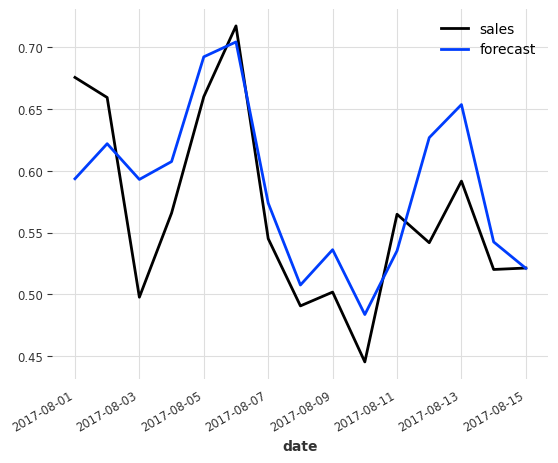

In [84]:
# Regression Model - Ridge with standard features

future_cov = calendar_merged
past_cov = sales_transactions_merged

regression_model_1 = RegressionModel(model=Ridge(), lags=[-28,-7,-1], lags_future_covariates=[-28,-7,-1], lags_past_covariates=[-28,-7,-1], output_chunk_length=15)
regression_model_1.fit(train, past_covariates=past_cov, future_covariates=future_cov)
regression_forecast_1 = regression_model_1.predict(15)

daily_scaled[train_length:].plot()
regression_forecast_1.plot(label='forecast')

In [85]:
# Compute error metrics
compute_error_metrics(test, regression_forecast_1)

MAE: 0.04130373069741498
MAPE: 7.401756923455566
SMAPE: 7.169814341052038
RMSE: 0.04927075929759277


In [86]:
# Backtest

<Axes: xlabel='date'>

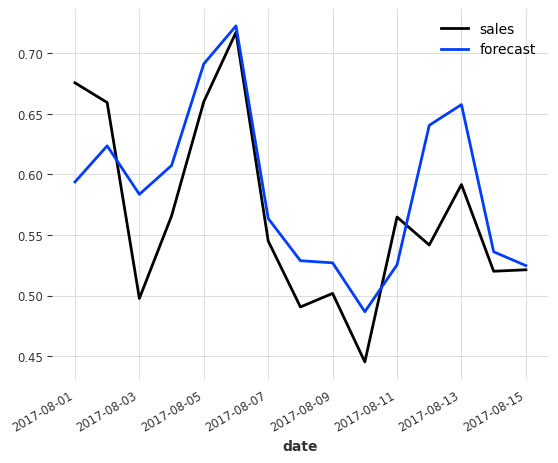

In [87]:
# Regression Model - Ridge with macro features

future_cov = calendar_merged
past_cov = sales_transactions_merged.concatenate(macro_merged, axis=1)

regression_model_2 = RegressionModel(model=Ridge(), lags=[-28,-7,-1], lags_future_covariates=[-28,-7,-1], lags_past_covariates=[-28,-7,-1], output_chunk_length=15)
regression_model_2.fit(train, past_covariates=past_cov, future_covariates=future_cov)
regression_forecast_2 = regression_model_2.predict(15)

daily_scaled[train_length:].plot()
regression_forecast_2.plot(label='forecast')

In [88]:
# Compute error metrics
compute_error_metrics(test, regression_forecast_2)

MAE: 0.04193016305544116
MAPE: 7.5534333963481375
SMAPE: 7.312685437482959
RMSE: 0.050469604565727744


In [89]:
# Backtest

<Axes: xlabel='date'>

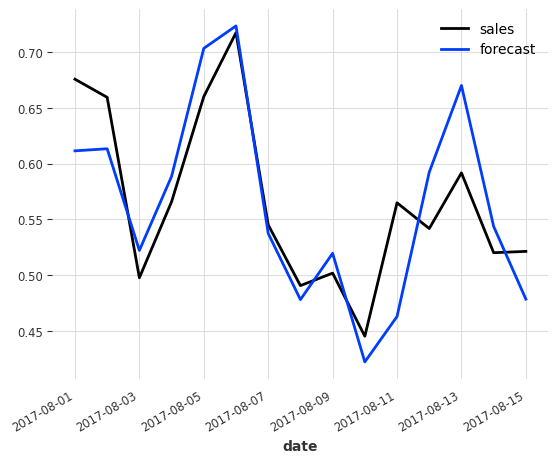

In [90]:
# Linear Regression - with standard features

future_cov = calendar_merged
past_cov = sales_transactions_merged

linear_regression_model_1 = LinearRegressionModel(lags=[-28,-7,-1], lags_future_covariates=[-28,-7,-1], lags_past_covariates=[-28,-7,-1])
linear_regression_model_1.fit(train, past_covariates=past_cov, future_covariates=future_cov)
linear_regression_forecast_1 = linear_regression_model_1.predict(15, past_covariates=past_cov, future_covariates=future_cov)

daily_scaled[train_length:].plot()
linear_regression_forecast_1.plot(label='forecast')

In [91]:
# Compute error metrics
compute_error_metrics(test, linear_regression_forecast_1)

MAE: 0.03767113935993116
MAPE: 6.591672645195447
SMAPE: 6.674397247970067
RMSE: 0.04604793298110394


In [92]:
# Backtest

<Axes: xlabel='date'>

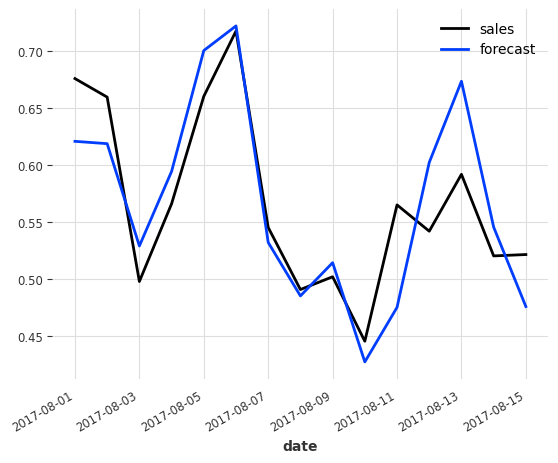

In [93]:
# Linear Regression - with macro features

future_cov = calendar_merged
past_cov = sales_transactions_merged.concatenate(macro_merged, axis=1)

linear_regression_model_2 = LinearRegressionModel(lags=[-28,-7,-1], lags_future_covariates=[-28,-7,-1], lags_past_covariates=[-28,-7,-1])
linear_regression_model_2.fit(train, past_covariates=past_cov, future_covariates=future_cov)
linear_regression_forecast_2 = linear_regression_model_2.predict(15, past_covariates=past_cov, future_covariates=future_cov)

daily_scaled[train_length:].plot()
linear_regression_forecast_2.plot(label='forecast')

In [94]:
# Compute error metrics
compute_error_metrics(test, linear_regression_forecast_2)

MAE: 0.036801769548269116
MAPE: 6.4580705143498625
SMAPE: 6.479686130651334
RMSE: 0.044641863469115015


In [95]:
# Backtest

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13023
[LightGBM] [Info] Number of data points in the train set: 1631, number of used features: 60
[LightGBM] [Info] Start training from score 0.435809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13023
[LightGBM] [Info] Number of data points in the train set: 1631, number of used features: 60
[LightGBM] [Info] Start training from score 0.436004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13023
[LightGBM] [Info] Number of data points in the train set: 1631, number of used features: 60
[LightGBM] [Info] Start tra

<Axes: xlabel='date'>

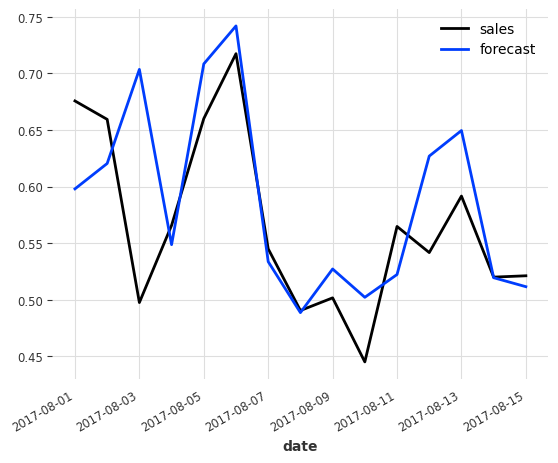

In [96]:
#LightGBM - with standard features

future_cov = calendar_merged
past_cov = sales_transactions_merged

lightgbm_model_1 = LightGBMModel(lags=[-28,-7,-1], lags_future_covariates=[-28,-7,-1], lags_past_covariates=[-28,-7,-1], output_chunk_length=15)
lightgbm_model_1.fit(train, past_covariates=past_cov, future_covariates=future_cov)
lightgbm_forecast_1 = lightgbm_model_1.predict(15, past_covariates=past_cov, future_covariates=future_cov)

daily_scaled[train_length:].plot()
lightgbm_forecast_1.plot(label='forecast')

In [97]:
# Compute error metrics
compute_error_metrics(test, lightgbm_forecast_1)

MAE: 0.04691225554451866
MAPE: 8.522109024707726
SMAPE: 7.94568085176093
RMSE: 0.06816100172357485


In [98]:
# Backtest

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31383
[LightGBM] [Info] Number of data points in the train set: 1631, number of used features: 132
[LightGBM] [Info] Start training from score 0.435809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31383
[LightGBM] [Info] Number of data points in the train set: 1631, number of used features: 132
[LightGBM] [Info] Start training from score 0.436004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31383
[LightGBM] [Info] Number of data points in the train set: 1631, number of used features: 132
[LightGBM] [Info] Start 

<Axes: xlabel='date'>

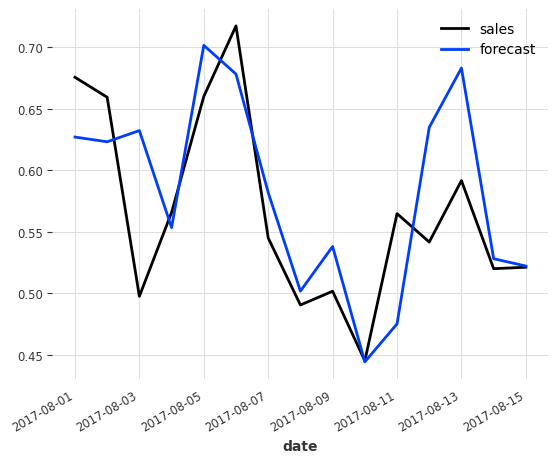

In [99]:
# LightGBM - with macro features

future_cov = calendar_merged
past_cov = sales_transactions_merged.concatenate(macro_merged, axis=1)

lightgbm_model_2 = LightGBMModel(lags=[-28,-7,-1], lags_future_covariates=[-28,-7,-1], lags_past_covariates=[-28,-7,-1], output_chunk_length=15)
lightgbm_model_2.fit(train, past_covariates=past_cov, future_covariates=future_cov)
lightgbm_forecast_2 = lightgbm_model_2.predict(15, past_covariates=past_cov, future_covariates=future_cov)

daily_scaled[train_length:].plot()
lightgbm_forecast_2.plot(label='forecast')

In [100]:
# Compute error metrics
compute_error_metrics(test, lightgbm_forecast_2)

MAE: 0.04541127058268989
MAPE: 8.029852280006892
SMAPE: 7.733965560813478
RMSE: 0.05953876313988211


<Axes: xlabel='date'>

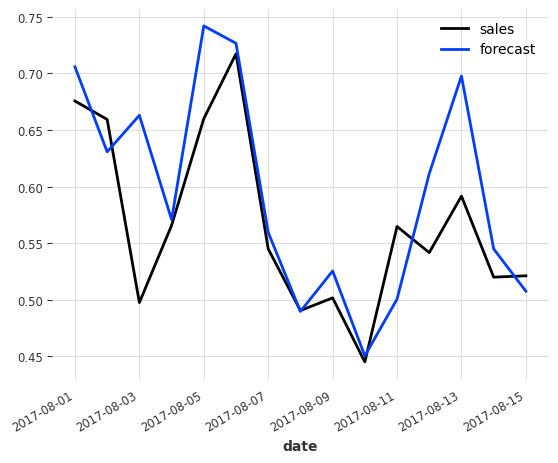

In [101]:
#XGBM - with standard features

future_cov = calendar_merged
past_cov = sales_transactions_merged

xgbm_model_1 = XGBModel(lags=[-28,-7,-1], lags_future_covariates=[-28,-7,-1], lags_past_covariates=[-28,-7,-1], output_chunk_length=15)
xgbm_model_1.fit(train, past_covariates=past_cov, future_covariates=future_cov)
xgbm_forecast_1 = xgbm_model_1.predict(15, past_covariates=past_cov, future_covariates=future_cov)

daily_scaled[train_length:].plot()
xgbm_forecast_1.plot(label='forecast')

In [102]:
# Compute error metrics
compute_error_metrics(test, xgbm_forecast_1)

MAE: 0.04289741833556442
MAPE: 7.66553707625478
SMAPE: 7.180448355719509
RMSE: 0.062050467476242016


<Axes: xlabel='date'>

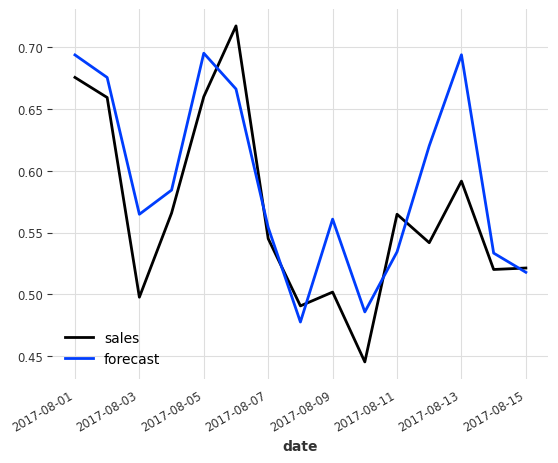

In [103]:
#XGBM - with macro features

future_cov = calendar_merged
past_cov = sales_transactions_merged.concatenate(macro_merged, axis=1)

xgbm_model_2 = XGBModel(lags=[-28,-7,-1], lags_future_covariates=[-28,-7,-1], lags_past_covariates=[-28,-7,-1], output_chunk_length=15)
xgbm_model_2.fit(train, past_covariates=past_cov, future_covariates=future_cov)
xgbm_forecast_2 = xgbm_model_2.predict(15, past_covariates=past_cov, future_covariates=future_cov)

daily_scaled[train_length:].plot()
xgbm_forecast_2.plot(label='forecast')

In [104]:
# Compute error metrics
compute_error_metrics(test, xgbm_forecast_2)

MAE: 0.03708399944010956
MAPE: 6.666163640642167
SMAPE: 6.3920456026857675
RMSE: 0.046504356842539854


<Axes: xlabel='date'>

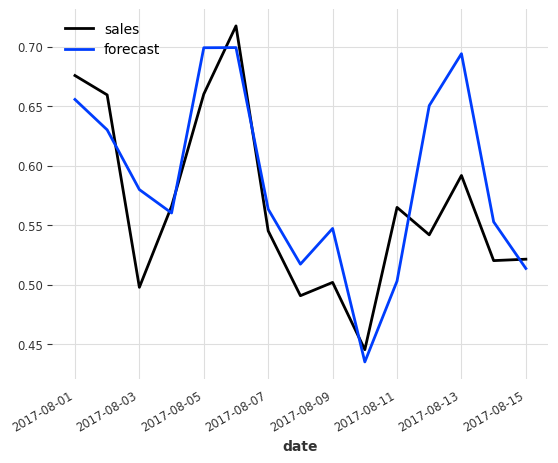

In [105]:
# CatBoost - with standard features

future_cov = calendar_merged
past_cov = sales_transactions_merged

catboost_model_1 = CatBoostModel(lags=[-28,-7,-1], lags_future_covariates=[-28,-7,-1], lags_past_covariates=[-28,-7,-1], output_chunk_length=15)
catboost_model_1.fit(train, past_covariates=past_cov, future_covariates=future_cov)
catboost_forecast_1 = catboost_model_1.predict(15, past_covariates=past_cov, future_covariates=future_cov)

daily_scaled[train_length:].plot()
catboost_forecast_1.plot(label='forecast')

In [106]:
# Compute error metrics
compute_error_metrics(test, catboost_forecast_1)

MAE: 0.040548021303153006
MAPE: 7.304607478903034
SMAPE: 7.00116925819312
RMSE: 0.05185566729656086


<Axes: xlabel='date'>

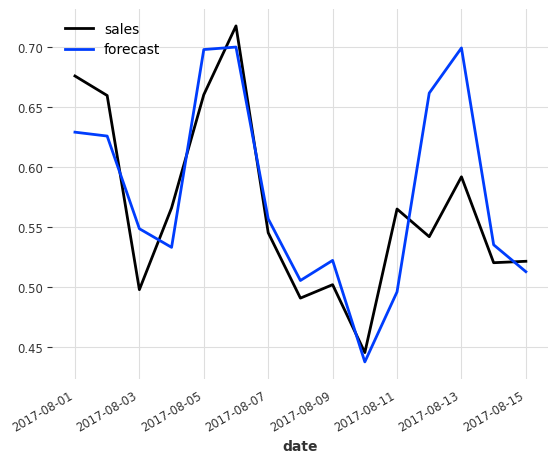

In [107]:
# CatBoost - with macro features

future_cov = calendar_merged
past_cov = sales_transactions_merged.concatenate(macro_merged, axis=1)

catboost_model_2 = CatBoostModel(lags=[-28,-7,-1], lags_future_covariates=[-28,-7,-1], lags_past_covariates=[-28,-7,-1], output_chunk_length=15)
catboost_model_2.fit(train, past_covariates=past_cov, future_covariates=future_cov)
catboost_forecast_2 = catboost_model_2.predict(15, past_covariates=past_cov, future_covariates=future_cov)

daily_scaled[train_length:].plot()
catboost_forecast_2.plot(label='forecast')

In [108]:
# Compute error metrics
compute_error_metrics(test, catboost_forecast_2)

MAE: 0.03956366988464941
MAPE: 6.941114555731321
SMAPE: 6.732213534480061
RMSE: 0.05192973126341814


# Machine Learning and Deep Learning Models

Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date'>

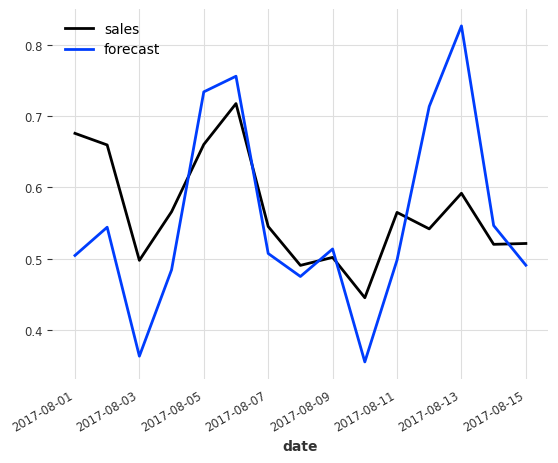

In [109]:
# N-HiTS - with standard features

past_cov = reindex_timeseries(sales_transactions_merged[:len(calendar_merged)].concatenate(calendar_merged, axis=1,ignore_time_axis=True))

nhits_model_1 = NHiTSModel(
    input_chunk_length=28,
    output_chunk_length=15,
    n_epochs=200,
    activation='Sigmoid'
)
nhits_model_1.fit(train.astype(np.float32), past_covariates=past_cov.astype(np.float32))
nhits_forecast_1 = nhits_model_1.predict(15, past_covariates=past_cov.astype(np.float32))

daily_scaled[train_length:].plot()
nhits_forecast_1.plot(label='forecast')

In [110]:
# Compute error metrics
compute_error_metrics(test, nhits_forecast_1)

MAE: 0.08660906730055347
MAPE: 15.162132688596252
SMAPE: 15.321547440935065
RMSE: 0.1078932441609084


In [111]:
# Backtest

Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date'>

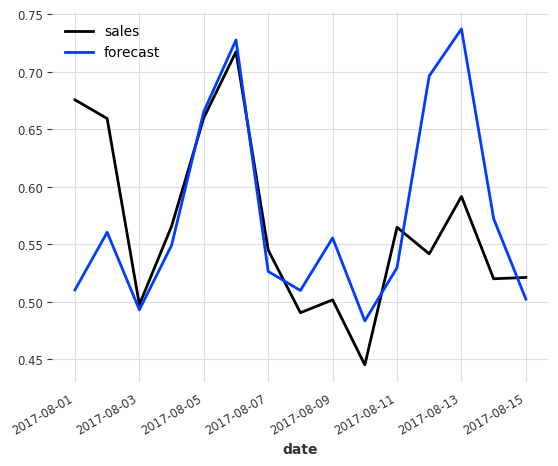

In [112]:
# N-HiTS - with macro features

past_cov = reindex_timeseries(sales_transactions_merged[:len(calendar_merged)].concatenate(calendar_merged, axis=1,ignore_time_axis=True)
.concatenate(macro_merged[:len(calendar_merged)], axis=1,ignore_time_axis=True))

nhits_model_2 = NHiTSModel(
    input_chunk_length=28,
    output_chunk_length=15,
    n_epochs=200,
    activation='Sigmoid'
)
nhits_model_2.fit(train.astype(np.float32), past_covariates=past_cov.astype(np.float32))
nhits_forecast_2 = nhits_model_2.predict(15)

daily_scaled[train_length:].plot()
nhits_forecast_2.plot(label='forecast')

In [113]:
# Compute error metrics
compute_error_metrics(test, nhits_forecast_2)

MAE: 0.05582351400560133
MAPE: 9.683052612668485
SMAPE: 9.50048323920949
RMSE: 0.07832779352428028


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date'>

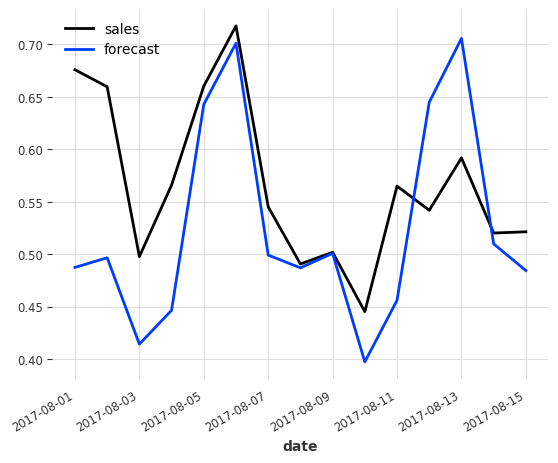

In [114]:
#Block RNN - with standard features

past_cov = reindex_timeseries(sales_transactions_merged[:len(calendar_merged)].concatenate(calendar_merged, axis=1,ignore_time_axis=True))

block_rnn_model_1 = BlockRNNModel(
    input_chunk_length=28,
    output_chunk_length=15,
    n_rnn_layers=2,
    n_epochs=200,
)
block_rnn_model_1.fit(train.astype(np.float32), past_covariates=past_cov.astype(np.float32))
block_rnn_forecast_1 = block_rnn_model_1.predict(15, past_covariates=past_cov.astype(np.float32))

daily_scaled[train_length:].plot()
block_rnn_forecast_1.plot(label='forecast')

In [115]:
# Compute error metrics
compute_error_metrics(test, block_rnn_forecast_1)

MAE: 0.0705960443325734
MAPE: 12.135468656050957
SMAPE: 12.93881680930605
RMSE: 0.09128019441473878


In [116]:
# Backtest

Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date'>

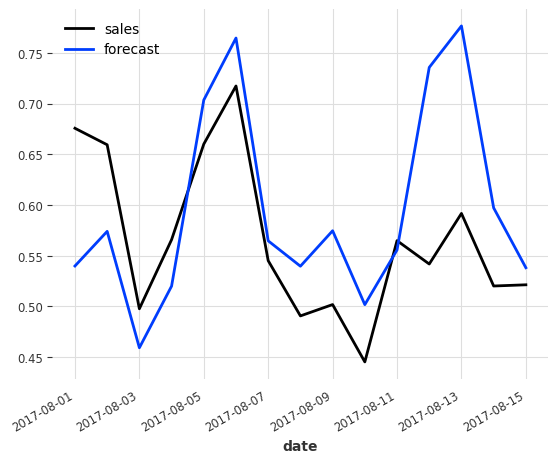

In [117]:
#Block RNN - with macro features

past_cov = reindex_timeseries(sales_transactions_merged[:len(calendar_merged)].concatenate(calendar_merged, axis=1,ignore_time_axis=True)
.concatenate(macro_merged[:len(calendar_merged)], axis=1,ignore_time_axis=True))

block_rnn_model_2 = BlockRNNModel(
    input_chunk_length=28,
    output_chunk_length=15,
    n_rnn_layers=2,
    n_epochs=200)

block_rnn_model_2.fit(train.astype(np.float32), past_covariates=past_cov.astype(np.float32))
block_rnn_forecast_2 = block_rnn_model_2.predict(15)

daily_scaled[train_length:].plot()
block_rnn_forecast_2.plot(label='forecast')

In [118]:
# Compute error metrics
compute_error_metrics(test, block_rnn_forecast_2)

MAE: 0.07173442558234878
MAPE: 12.636881092012601
SMAPE: 11.995691538070405
RMSE: 0.09048817961351024


In [119]:
# Backtest

# Hybrid Models

Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date'>

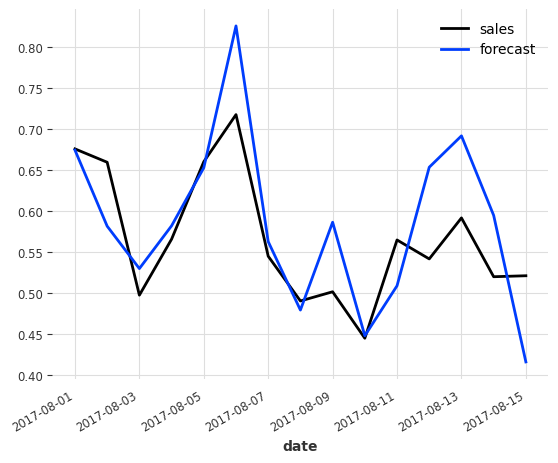

In [120]:
# TFTModel - with standard features

future_cov = calendar_merged
past_cov = sales_transactions_merged

tft_model_1 = TFTModel(
    input_chunk_length=28,
    output_chunk_length=15,
    n_epochs=200)

tft_model_1.fit(train.astype(np.float32), past_covariates=past_cov.astype(np.float32), future_covariates=future_cov.astype(np.float32))
tft_forecast_1 = tft_model_1.predict(15, past_covariates=past_cov.astype(np.float32), future_covariates=future_cov.astype(np.float32))

daily_scaled[train_length:].plot()
tft_forecast_1.plot(label='forecast')

In [121]:
# Compute error metrics
compute_error_metrics(test, tft_forecast_1)

MAE: 0.0537574081636069
MAPE: 9.495461028905579
SMAPE: 9.273539112504121
RMSE: 0.0677081006241633


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date'>

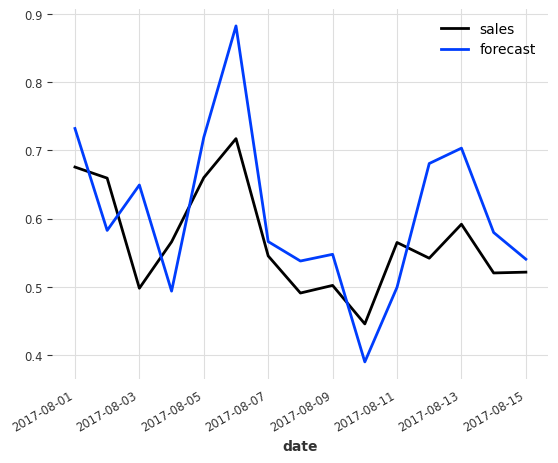

In [122]:
# TFT Model - with macro features

future_cov = calendar_merged
past_cov = sales_transactions_merged.concatenate(macro_merged, axis=1)

tft_model_2 = TFTModel(
    input_chunk_length=28,
    output_chunk_length=15,
    n_epochs=200)

tft_model_2.fit(train.astype(np.float32), past_covariates=past_cov.astype(np.float32), future_covariates=future_cov.astype(np.float32))
tft_forecast_2 = tft_model_2.predict(15, past_covariates=past_cov.astype(np.float32), future_covariates=future_cov.astype(np.float32))

daily_scaled[train_length:].plot()
tft_forecast_2.plot(label='forecast')

In [123]:
# Compute error metrics
compute_error_metrics(test, tft_forecast_2)

MAE: 0.07646737487601604
MAPE: 13.449401078233532
SMAPE: 12.774034115477013
RMSE: 0.08801396312573992


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date'>

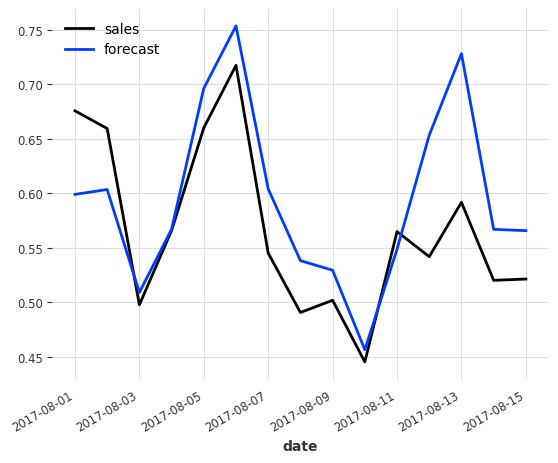

In [124]:
#TSMixer Model - with standard features
future_cov = calendar_merged
past_cov = sales_transactions_merged

tsm_model_1 = TSMixerModel(
    input_chunk_length=28,
    output_chunk_length=15,
    use_reversible_instance_norm=True,
    n_epochs=200)

tsm_model_1.fit(train.astype(np.float32), past_covariates=past_cov.astype(np.float32), future_covariates=future_cov.astype(np.float32))
tsm_forecast_1 = tsm_model_1.predict(15, past_covariates=past_cov.astype(np.float32), future_covariates=future_cov.astype(np.float32))

daily_scaled[train_length:].plot()
tsm_forecast_1.plot(label='forecast')

In [125]:
# Compute error metrics
compute_error_metrics(test, tsm_forecast_1)

MAE: 0.0478761874736061
MAPE: 8.35936169102673
SMAPE: 7.998247156641372
RMSE: 0.059922273583342504


Training: |                                               | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

<Axes: xlabel='date'>

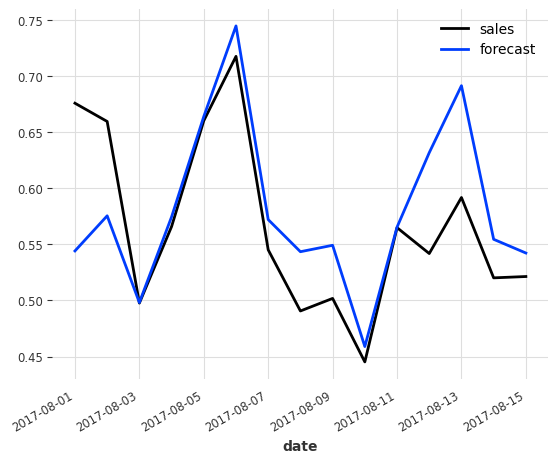

In [129]:
#TSMixer Model - with macro features
future_cov = calendar_merged
past_cov = sales_transactions_merged.concatenate(macro_merged, axis=1)

tsm_model_2 = TSMixerModel(
    input_chunk_length=28,
    output_chunk_length=15,
    use_reversible_instance_norm=True,
    n_epochs=200
)

tsm_model_2.fit(train.astype(np.float32), past_covariates=past_cov.astype(np.float32), future_covariates=future_cov.astype(np.float32))
tsm_forecast_2 = tsm_model_2.predict(15, past_covariates=past_cov.astype(np.float32), future_covariates=future_cov.astype(np.float32))

daily_scaled[train_length:].plot()
tsm_forecast_2.plot(label='forecast')

In [130]:
# Compute error metrics
compute_error_metrics(test, tsm_forecast_2)

MAE: 0.042762681880349845
MAPE: 7.36700948663979
SMAPE: 7.292237116121935
RMSE: 0.05816022436614597
